<a href="https://colab.research.google.com/github/pds1920/capstone-group-6/blob/master/Training/Small_retrain_mixup_customtransforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q kaggle

In [0]:
# mounting gdrive um daten runterzuladen wenn nötig
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/PDS/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
 # kaggle.json
 from google.colab import files
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"michipds","key":"2924b7242071b81425b660f2b1a5bd87"}'}

In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
import pandas as pd
import numpy as np

In [0]:
path_img = "/content/gdrive/My Drive/train"

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path_img, train=".",
                                  ds_tfms=get_transforms(),
                                  valid_pct=0.2,
                                  size=64,
                                  bs=64,
                                  ).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 78.1MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


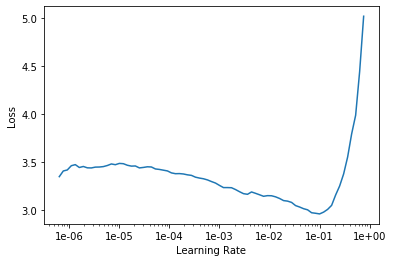

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(20, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.156997,2.131620,0.310436,05:41
1,2.740621,1.732924,0.470277,01:38
2,2.394779,1.383021,0.573316,01:38
3,2.093388,1.206732,0.608983,01:38
4,1.815623,1.115106,0.673712,01:38
5,1.594773,0.882214,0.708058,01:39
6,1.357359,0.780334,0.742404,01:38
7,1.191729,0.698330,0.771466,01:38
8,1.050656,0.601506,0.799207,01:38
9,0.968645,0.540631,0.824306,01:38


In [0]:
learn.save("64-stage1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


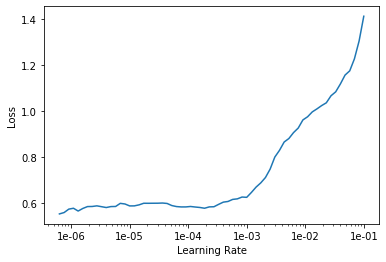

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(20, max_lr=slice(1e-5, 1e-3), callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name="64_retrain")])


epoch,train_loss,valid_loss,accuracy,time
0,0.537268,0.401194,0.870542,01:40
1,0.547151,0.383347,0.881110,01:37
2,0.555694,0.387340,0.870542,01:35
3,0.512561,0.400469,0.885073,01:34
4,0.480929,0.323629,0.898283,01:32
5,0.439693,0.386240,0.890357,01:32
6,0.398001,0.305072,0.912814,01:31
7,0.360929,0.286647,0.923382,01:32
8,0.306655,0.280197,0.928666,01:31
9,0.278671,0.279167,0.928666,01:30


Better model found at epoch 0 with accuracy value: 0.8705416321754456.
Better model found at epoch 1 with accuracy value: 0.8811096549034119.
Better model found at epoch 3 with accuracy value: 0.885072648525238.
Better model found at epoch 4 with accuracy value: 0.8982827067375183.
Better model found at epoch 6 with accuracy value: 0.9128137230873108.
Better model found at epoch 7 with accuracy value: 0.9233817458152771.
Better model found at epoch 8 with accuracy value: 0.9286657571792603.
Better model found at epoch 10 with accuracy value: 0.9418758153915405.
Better model found at epoch 14 with accuracy value: 0.9471598267555237.


In [0]:
data = ImageDataBunch.from_folder(path_img, train=".",
                                  ds_tfms=get_transforms(),
                                  valid_pct=0.2,
                                  size=128,
                                  bs=32,
                                  ).normalize(imagenet_stats)
learn.data= data

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


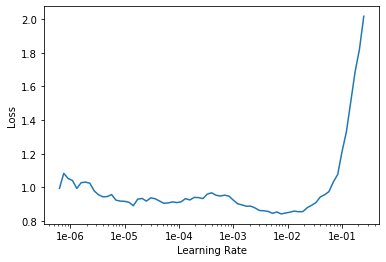

In [0]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(20, max_lr=1e-3, callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name="128_retrain")])

epoch,train_loss,valid_loss,accuracy,time
0,0.825633,0.350990,0.875826,01:52
1,0.649419,0.269394,0.896962,01:51
2,0.521124,0.256938,0.914135,01:51
3,0.408702,0.202945,0.935271,01:51
4,0.351537,0.181728,0.932629,01:50
5,0.332183,0.163346,0.947160,01:49
6,0.320467,0.146731,0.953765,01:49
7,0.278408,0.129477,0.959049,01:49
8,0.256571,0.124185,0.963012,01:49
9,0.229711,0.122607,0.965654,01:49


Better model found at epoch 0 with accuracy value: 0.8758256435394287.
Better model found at epoch 1 with accuracy value: 0.8969616889953613.
Better model found at epoch 2 with accuracy value: 0.9141347408294678.
Better model found at epoch 3 with accuracy value: 0.9352707862854004.
Better model found at epoch 5 with accuracy value: 0.9471598267555237.
Better model found at epoch 6 with accuracy value: 0.9537648558616638.
Better model found at epoch 7 with accuracy value: 0.959048867225647.
Better model found at epoch 8 with accuracy value: 0.9630118608474731.
Better model found at epoch 9 with accuracy value: 0.9656538963317871.
Better model found at epoch 14 with accuracy value: 0.9669749140739441.
Better model found at epoch 17 with accuracy value: 0.9696168899536133.
Better model found at epoch 18 with accuracy value: 0.9709379076957703.


In [0]:
learn.export("128retrain")

In [0]:
data = ImageDataBunch.from_folder(path_img, train=".",
                                  ds_tfms=get_transforms(),
                                  valid_pct=0.2,
                                  size=128,
                                  bs=32,
                                  ).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy).load("/content/gdrive/My Drive/train/models/128_retrain")

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


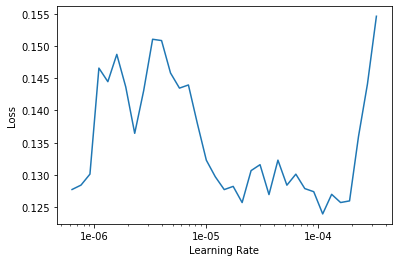

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(20, max_lr=slice(1e-5, 1e-3), callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name="128_retrain_s2")])

epoch,train_loss,valid_loss,accuracy,time
0,0.139169,0.054700,0.977543,13:31
1,0.145018,0.059675,0.977543,01:48
2,0.188122,0.096514,0.970938,01:47
3,0.254151,0.307060,0.928666,01:48
4,0.231774,0.242190,0.933950,01:49
5,0.285414,0.282933,0.926024,01:49
6,0.238100,0.150185,0.952444,01:49
7,0.185084,0.274725,0.944518,01:49
8,0.167463,0.180392,0.959049,01:50
9,0.168387,0.202573,0.940555,01:50


Better model found at epoch 0 with accuracy value: 0.9775429368019104.


KeyboardInterrupt: ignored

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy).load("/content/gdrive/My Drive/train/models/128_retrain_s2")

In [0]:
learn.data.add_test(ImageList.from_folder("/content/gdrive/My Drive/test_stg1"))
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
names_stg1 = [x.name for x in learn.data.test_ds.items]
res_stg1 = pd.DataFrame(preds.numpy(), columns=learn.data.classes)
res_stg1.insert(0, 'image', names_stg1)

In [0]:
learn.data.add_test(ImageList.from_folder("/content/gdrive/My Drive/test_stg2"))
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
names_stg2 = ['test_stg2/'+x.name for x in learn.data.test_ds.items]
res_stg2 = pd.DataFrame(preds.numpy(), columns=learn.data.classes)
res_stg2.insert(0, 'image', names_stg2)

In [0]:
pd.concat([res_stg1, res_stg2]).to_csv('submissionsmallretrain.csv', index=False)

Private Score: 3.89521

Public Score: 1.95696

Test out custom transforms

In [0]:
doc(get_transforms)

In [0]:
tfms = get_transforms(max_rotate=10, max_zoom=1.6, max_lighting=0.8, max_warp=0.4,
                      p_affine=0.8, p_lighting=1.)

* Increase max_lighting because some of the pictures are very dark

* Also increased zoom because the fish often only take up a tiny part of the image

In [0]:
path_img= "/content/gdrive/My Drive/train"

In [0]:
data = ImageDataBunch.from_folder(path_img, train=".",
                                  ds_tfms=get_transforms(max_rotate=10, max_zoom=1.6, max_lighting=0.8, max_warp=0.4,
                                  p_affine=0.8, p_lighting=1.),
                                  valid_pct=0.2,
                                  size=224,
                                  bs=32,
                                  ).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy).mixup()

* Test out Mixup

Mixup is a neat little data augmentation trick. In mixup, instead of feeding our network raw images, we take 2 images and do a linear combination of them


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


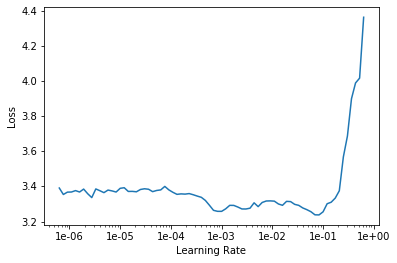

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(20, max_lr=1e-3, callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name="mixup_s1")])

epoch,train_loss,valid_loss,accuracy,time
0,3.068066,1.896386,0.421400,02:35
1,2.674712,1.619158,0.479524,02:35
2,2.374012,1.410437,0.528402,02:35
3,2.098970,1.028179,0.668428,02:36
4,1.824261,0.944665,0.680317,02:36
5,1.609428,0.775680,0.747688,02:37
6,1.474828,0.692857,0.775429,02:37
7,1.384985,0.691780,0.780713,02:38
8,1.339226,0.643080,0.784676,02:38
9,1.282616,0.671688,0.783355,02:39


Better model found at epoch 0 with accuracy value: 0.4214002788066864.
Better model found at epoch 1 with accuracy value: 0.4795244336128235.
Better model found at epoch 2 with accuracy value: 0.5284016132354736.
Better model found at epoch 3 with accuracy value: 0.6684280037879944.
Better model found at epoch 4 with accuracy value: 0.6803170442581177.
Better model found at epoch 5 with accuracy value: 0.7476882338523865.
Better model found at epoch 6 with accuracy value: 0.7754293084144592.
Better model found at epoch 7 with accuracy value: 0.7807133197784424.
Better model found at epoch 8 with accuracy value: 0.7846763730049133.
Better model found at epoch 10 with accuracy value: 0.8110964298248291.
Better model found at epoch 11 with accuracy value: 0.8229854702949524.
Better model found at epoch 13 with accuracy value: 0.848084568977356.
Better model found at epoch 14 with accuracy value: 0.8599736094474792.
Better model found at epoch 17 with accuracy value: 0.8639366030693054.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


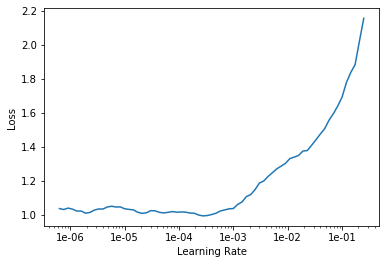

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()


In [0]:
learn.fit_one_cycle(20, max_lr=slice(1e-5, 1e-3), callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name="mixup_s2")])

epoch,train_loss,valid_loss,accuracy,time
0,1.038492,0.424755,0.853369,02:39
1,1.046712,0.382042,0.882431,02:39
2,1.046443,0.367950,0.890357,02:40
3,1.022046,0.391081,0.873184,02:41
4,1.033162,0.433501,0.863937,02:42
5,0.992674,0.358456,0.885073,02:42
6,0.962484,0.427316,0.878468,02:42
7,0.982732,0.338189,0.900925,02:43
8,0.951793,0.334222,0.900925,02:42
9,0.910783,0.306608,0.908851,02:44


Better model found at epoch 0 with accuracy value: 0.8533685803413391.
Better model found at epoch 1 with accuracy value: 0.8824306726455688.
Better model found at epoch 2 with accuracy value: 0.8903566598892212.
Better model found at epoch 7 with accuracy value: 0.9009246826171875.
Better model found at epoch 9 with accuracy value: 0.9088507294654846.
Better model found at epoch 10 with accuracy value: 0.927344799041748.
Better model found at epoch 13 with accuracy value: 0.9418758153915405.
Better model found at epoch 16 with accuracy value: 0.9471598267555237.


In [0]:
data = ImageDataBunch.from_folder(path_img, train=".",
                                  ds_tfms=get_transforms(max_rotate=10, max_zoom=1.6, max_lighting=0.8, max_warp=0.4,
                                  p_affine=0.8, p_lighting=1.),
                                  valid_pct=0.2,
                                  size=480,
                                  bs=32,
                                  ).normalize(imagenet_stats)

#learn.data = data

In [0]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


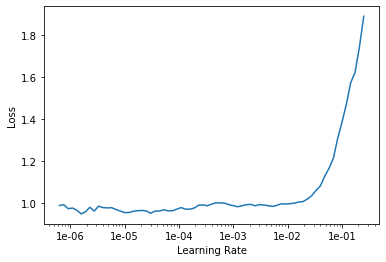

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(20, max_lr=1e-6, callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name="mixup480_s1")])

epoch,train_loss,valid_loss,accuracy,time
0,0.975308,0.251479,0.929987,03:50
1,0.966830,0.255689,0.933950,03:49
2,0.963937,0.242929,0.941876,03:47
3,0.973414,0.250258,0.933950,03:48
4,0.980577,0.245007,0.936592,03:48
5,0.952808,0.253811,0.936592,03:49
6,0.967669,0.248249,0.935271,03:48
7,0.994162,0.248119,0.936592,03:49
8,0.988938,0.244632,0.936592,03:48
9,0.954374,0.247994,0.933950,03:50


Better model found at epoch 0 with accuracy value: 0.9299867749214172.
Better model found at epoch 1 with accuracy value: 0.9339498281478882.
Better model found at epoch 2 with accuracy value: 0.9418758153915405.


In [0]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy).mixup().load("/content/gdrive/My Drive/train/models/mixup480_s1")

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


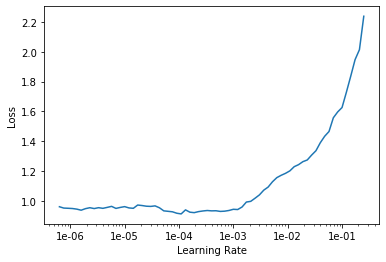

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(20, max_lr=slice(1e-5, 1e-3), callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name="mixup480_s2")])

epoch,train_loss,valid_loss,accuracy,time
0,0.939401,0.193398,0.943197,03:53
1,0.876128,0.172451,0.945839,03:53
2,0.860616,0.182003,0.937913,03:56
3,0.853117,0.246349,0.919419,03:56
4,0.824690,0.303089,0.910172,03:58
5,0.833877,0.266269,0.923382,03:59
6,0.806596,0.252335,0.920740,03:59
7,0.839870,0.206385,0.937913,04:00
8,0.811052,0.222954,0.945839,03:59
9,0.820287,0.233361,0.944518,04:01


Better model found at epoch 0 with accuracy value: 0.9431968331336975.
Better model found at epoch 1 with accuracy value: 0.9458388090133667.
Better model found at epoch 11 with accuracy value: 0.9524438381195068.
Better model found at epoch 14 with accuracy value: 0.9550858736038208.
Better model found at epoch 15 with accuracy value: 0.95772784948349.
Better model found at epoch 16 with accuracy value: 0.959048867225647.
Better model found at epoch 18 with accuracy value: 0.960369884967804.


In [0]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy).mixup().load("/content/gdrive/My Drive/train/models/mixup480_s2")

In [0]:
learn.data.add_test(ImageList.from_folder("/content/gdrive/My Drive/test_stg1"))
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
names_stg1 = [x.name for x in learn.data.test_ds.items]
res_stg1 = pd.DataFrame(preds.numpy(), columns=learn.data.classes)
res_stg1.insert(0, 'image', names_stg1)

In [0]:
learn.data.add_test(ImageList.from_folder("/content/gdrive/My Drive/test_stg2"))
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
names_stg2 = ['test_stg2/'+x.name for x in learn.data.test_ds.items]
res_stg2 = pd.DataFrame(preds.numpy(), columns=learn.data.classes)
res_stg2.insert(0, 'image', names_stg2)

In [0]:
pd.concat([res_stg1, res_stg2]).to_csv('submissionsmixup_customtransforms.csv', index=False)

Best kaggle score for single model!!!!

Private Score: 1.62824

Public Score: 0.92854